# 第10章
## 階層ベイズモデル：GLMMのベイズモデル化

無情報事前分布と階層事前分布、この2種類の事前分布を使って、GLMMのベイズ版である階層ベイズモデルを作る


　　この章では   
  
　　　　**階層事前分布(hierarchical prior)**を使って  
    
　　　　　　**一般化線形混合モデル(GLMM)**を  
      
　　　　　　　　**階層ベイズモデル(hierarchical Bayesian model)**  
        
　　　　　　　　　　として扱う方法を説明する


## 10.1 例題：個体差と生存種子数（個体差あり）

> 各個体から8個の種子を採集

> 個体$i$において生存している種子$y_i$を調べた

> 調査した個体数は100

<img  src="fig. 10.1a.jpg"/>

このデータの構造は「個体$i$では8個の調査種子のうち$y_i$個が生存」となっているから<font color="Red">二項分布</font>が使えそう。

In [1]:
options(repr.plot.width=4, repr.plot.height=4)

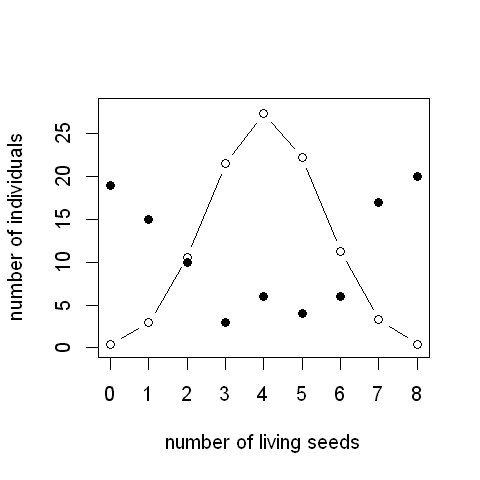

In [2]:
d <- read.csv("data7a.csv")

#fig. 10.1(B)
plot(table(d$y), type="p", pch = 16, ylim = c(0, 28),
     xlab = "number of living seeds",
     ylab = "number of individuals")
par(new=T)
plot(0:8, dbinom(0:8, 8, 0.504)*100, type="b", pch = 1, ylim = c(0, 28),
     xlab = "",
     ylab = "")

In [3]:
options(repr.plot.width=6, repr.plot.height=6)

しかしながら生存種子数のヒストグラムは、個体に由来するランダム効果によって<font color="Red">過分散</font>(overdispersion)が生じている。

全個体共通の生存確率$q$の二項分布で説明しようとすると、最尤推定値$\hat q$は<font color="Red">0.504</font>となる。

生起確率0.504で$N=8$の二項分布の分散は<font color="Red">2.00</font>くらいになると期待されるが、実際の観測データの分散は<font color="Red">9.93</font>であり、**過分散**。

## 10.2 GLMMの階層ベイズモデル化

例題のように個体ごとに由来する原因不明な差異などをくみこんだGLMがGLMM

しかし、個体差だけでなく場所差なども考慮するGLMMの場合は、パラメーターの最尤推定が困難

この章では、GLMではなくGLMMのベイズモデル化にとりくむ

ここで登場するGLMMでも、第７章と同じように、リンク関数と線形予測子を

$$logit(q_i)=\beta+r_i$$

とする。

> $\beta: 全個体共通のパラメーター$  
> $r_i: 個体差（平均0、標準偏差sの正規分布にしたがうと仮定）$

データが得られる確率$p({\bf Y}\mid\beta,\{r_i\})$は全100個体の二項分布の積なので、

$$p({\bf Y}\mid\beta,\{r_i\})=\prod_{i}\left(
\begin{array}{rr}
8 \\
y_i \\
\end{array}
\right){q_i}^{y_i}(1-q_i)^{8-y_i}$$

となる。推定したい事後分布は、

$$事後分布\propto p({\bf Y}\mid\beta,\{r_i\})\times 事前分布$$

となるので、あとは事前分布を指定すれば統計モデルの設計は完了。

線形予測子の切片$\beta$は正負どのような値をとってもよい実数

→<font color="Red">無情報事前分布</font>（平均0、標準偏差100のすごくひらべったい正規分布）を指定

$$p(\beta)=\frac{1}{\sqrt{2\pi \times 100^2}}\exp\left(
\frac{-\beta^2}{2\times 100^2}
\right)
$$

***
個体差$r_i$のパラメーターの事前分布はどうすればよいか？

→とりあえず平均0、<font color="Red">標準偏差$s$</font>の正規分布と仮定

$$p(r_i\mid s)=\frac{1}{\sqrt{2\pi s^2}}\exp\left(
\frac{-r_i^2}{2s^2}
\right)
$$

この個体差のばらつき<font color="Red">$s$</font>のあつかいは？

→ベイズ統計モデルでは確率分布である<font color="Red">$s$</font>の事後分布を推定

→事後分布の推定には、事前分布が必要

<font color="Red">$s$</font>については正の値であれば何でもかまわないので、事前分布$p(s)$を<font color="Red">無情報事前分布</font>とする。

$$p(s)=(0から10^4までの連続一様分布)$$

このように、  
個体差$r_i$の事前分布$p(r_i\mid s)$のカタチを決める<font color="Red">$s$</font>という未知パラメーターがあって、されにこの<font color="Red">$s$</font>についても事前分布$p(s)$が設定されているとき、$p(r_i\mid s)$を<font color="Red">**階層事前分布**</font>とよぶことがある。

また、事前分布$p(r_i\mid s)$のパラメーター<font color="Red">$s$</font>は超パラメーター(hyper parameter)、事前分布の事前分布である$p(s)$は超事前分布(hyper prior)とよばれることがある。

このような階層事前分布を使っているベイズ統計モデルが**<font color="Red">階層ベイズモデル</font>**。

## 10.3 階層ベイズモデルの推定・予測

ベイズモデルでは「推定したいパラメーター」はことごとく事前分布とデータにもとづいて事後分布が推定される。

つまり、この例題の階層ベイズモデルの事後分布は、

$$p(\beta,s,\{r_i\}\mid{\bf Y})\propto p({\bf Y}\mid\beta,\{r_i\})
　p(\beta)
　p(s)
　\prod_{i}p(r_i\mid s)$$

### 10.3.1 階層ベイズモデルのMCMCサンプリング

WinBUGSを使って事後分布$p(\beta,s,\{r_i\}\mid{\bf Y})$からMCMCサンプリングする。

BUGSコードで書くと、
```

model
{
	for (i in 1:N) {
		Y[i] ~ dbin(q[i], 8) # binomial distribution
		logit(q[i]) <- beta + r[i] # probability of living
	}
	beta ~ dnorm(0, 1.0E-4) # non-informative prior distribution
	for (i in 1:N) {
		r[i] ~ dnorm(0, tau) # hierarchical prior distribution
	}
	tau <- 1 / (s * s)	 # tau is inverse of variance
	s ~ dunif(0, 1.0E+4) # non-informative prior distribution
}

```

<img  src="fig. 10.2.jpg"/>

確率分布、リンク関数、線形予測子
```

    for (i in 1:N) {
		Y[i] ~ dbin(q[i], 8) # binomial distribution
		logit(q[i]) <- beta + r[i] # probability of living
	}
    
```
生存種子数Y[i]は生存確率q[i]でサイズ8の二項分布（dbin(q[i], 8)）にしたがう。
種子の生存確率q[i]は線形予測子beta + r[i]とロジスティック関数logit(q[i])で与えられる。

パラメーターの事前分布
```

	beta ~ dnorm(0, 1.0E-4) # non-informative prior distribution
	for (i in 1:N) {
		r[i] ~ dnorm(0, tau) # hierarchical prior distribution
	}
	tau <- 1 / (s * s)	 # tau is inverse of variance
	s ~ dunif(0, 1.0E+4) # non-informative prior distribution
    
```
betaの事前分布は平均0、標準偏差$10^2$の正規分布  
個体差r[i]の階層事前分布は平均0、標準偏差sの正規分布  
sの事前分布は$0$<$s$<$10^4$の一様分布

### 10.3.2 階層ベイズモデルの事後分布推定と予測

RとWinBUGSを使ってパラメーターの事後分布からのMCMCサンプリングをする

MCMCサンプリングの結果を使って、パラメーターごとの（周辺）事後分布を示す

推定された事後分布をくみあわせて、生存種子数ごとの個体数の分布を予測してみる

生存種子数$y$の確率分布は、二項分布$p(y\mid \beta ,r)$と正規分布$p(r\mid s)$の**無限混合分布**

$$p(y\mid \beta ,s)=\int_{-\infty}^\infty p(y\mid\beta,r)p(r\mid s) dr$$

$r$についての積分とは、事後分布にしたがうような植物を無限個あつめてきて、その平均を評価している――という意味

### Ｒで実行

In [4]:
source("http://hosho.ees.hokudai.ac.jp/~kubo/ce/r/R2WBwrapper.R") #ラッパー関数の読み込み(うまく読み込めない人)

# reading "R2WBwrapper.R" (written by kubo@ees.hokudai.ac.jp)...


Warning message:
"package 'R2WinBUGS' was built under R version 3.3.2"Loading required package: coda
Loading required package: boot


In [5]:
clear.data.param()
set.data("N", nrow(d))
set.data("Y", d$y)

set.param("beta", 0)
set.param("r", rnorm(N, 0, 0.1))
set.param("s", 1)
set.param("q", NA)

NULL

In [ ]:
post.bugs <- call.bugs(
  file = "model.bug.txt",
  n.iter = 10100, n.burnin = 100, n.thin = 10
)

＊なぜかRStudioではうまくいくのに、jupyter notebookでコマンドを走らせると実行中（\*マーク）のまま処理が返ってこない。  
→あらかじめRStudioで実行処理した結果を保存し、load()する。

In [6]:
load("Chap. 10.3.RData")

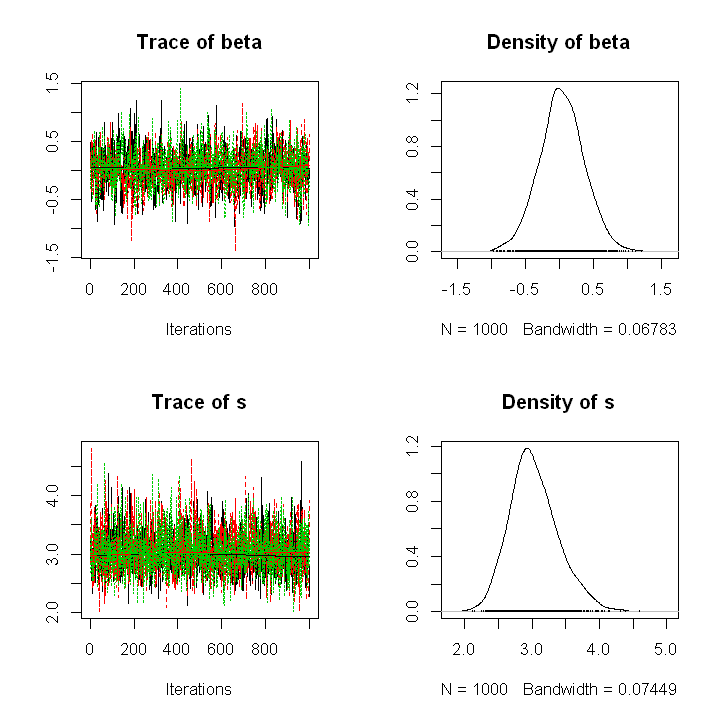

In [7]:
post.list <- to.list(post.bugs)
post.mcmc <- to.mcmc(post.bugs)
#fig. 10.3(A)(B)
s <- colnames(post.mcmc) %in% c("beta","s")
plot(post.list[,s,]) #"beta"と"s"の列を選択して図示
#fig. 10.3(C)(D)(E)

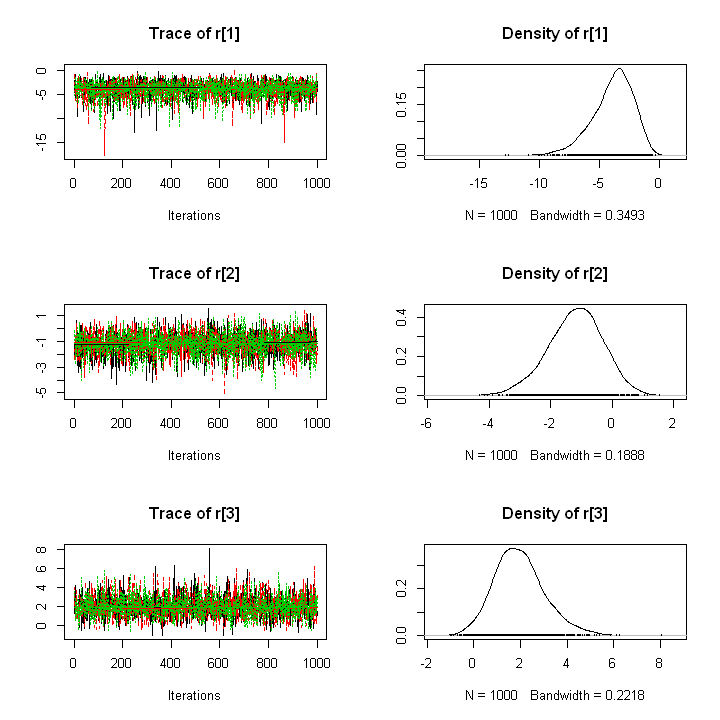

In [8]:
s <- colnames(post.mcmc) %in% c("r[1]","r[2]","r[3]")
plot(post.list[,s,]) #"r1","r2","r3"の列を選択して図示

In [9]:
#MCMCサンプリングの要約
print(post.bugs, digits.summary = 3)

Inference for Bugs model at "C:/Users/schaf/OneDrive/Documents/Ryo Nakahata/5.Statistic/R directry/model.bug.txt", fit using WinBUGS,
 3 chains, each with 10100 iterations (first 100 discarded), n.thin = 10
 n.sims = 3000 iterations saved
            mean     sd    2.5%     25%     50%     75%   97.5%  Rhat n.eff
beta       0.039  0.333  -0.618  -0.172   0.033   0.253   0.699 1.002  1600
r[1]      -3.877  1.784  -8.009  -4.822  -3.626  -2.633  -1.148 1.002  2300
r[2]      -1.200  0.896  -3.096  -1.776  -1.163  -0.593   0.458 1.001  3000
r[3]       1.970  1.099   0.018   1.220   1.880   2.610   4.435 1.001  3000
r[4]       3.820  1.737   1.036   2.549   3.651   4.817   7.637 1.001  3000
r[5]      -2.068  1.106  -4.465  -2.723  -1.978  -1.302  -0.158 1.001  3000
r[6]       1.989  1.085   0.122   1.250   1.902   2.652   4.334 1.002  1200
r[7]       3.775  1.807   0.928   2.492   3.511   4.820   7.962 1.001  3000
r[8]       3.803  1.770   1.047   2.483   3.583   4.870   7.837 1.001  3000
r

推定された事後分布をくみあわせて、生存種子数ごとの個体数の分布を予測

In [10]:
options(repr.plot.width=5, repr.plot.height=5)

# generating mp .............................. done


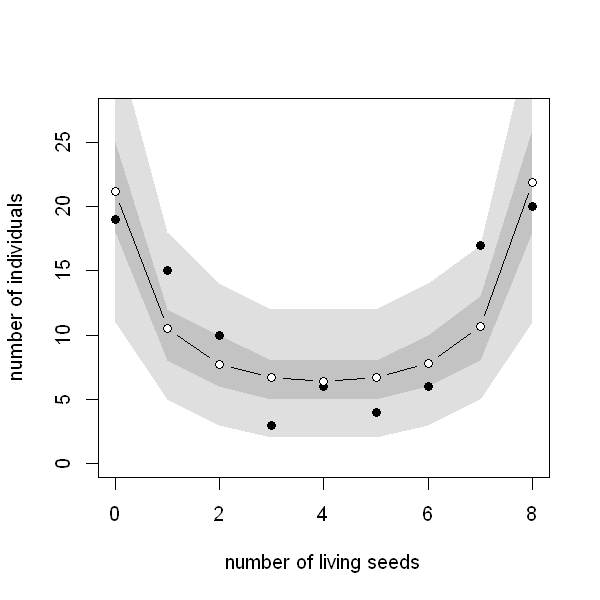

In [11]:
#fig. 10.4
post.mcmc <- as.mcmc(post.bugs$sims.matrix)

q <- sum(d$y) / (8 * nrow(d))
logistic <- function(z) 1 / (1 + exp(-z))
n <- nrow(d)
size <- 8
q <- sum(d$y) / (size * n)

f.gaussian.binom <- function(alpha, x, size, fixed, sd)
  dbinom(x, size, logistic(fixed + alpha)) * dnorm(alpha, 0, sd)

d.gaussian.binom <- function(v.x, size, fixed, sd) sapply(
  v.x, function(x) integrate(
    f = f.gaussian.binom,
    lower = -sd * 10,
    upper = sd * 10,
    # for f.gaussian.binom
    x = x,
    size = size,
    fixed = fixed,
    sd = sd
  )$value
)

plot.data <- function() plot(
  0:size, summary(as.factor(d$y)),
  ylim = range(c(0, dbinom(0:size, size, q) * n)),
  xlab = "number of living seeds",
  ylab = "number of individuals",
  pch = 19
)

plot.polygon <- function(mm, p)
{
  pp <- 1 - p
  qp <- apply(mm, 1, quantile, probs = c(0.5 * pp, 1 - 0.5 * pp))
  polygon(
    c(0:size, size:0),
    c(qp[1,], rev(qp[2,])),
    border = NA,
    col = "#00000020"
  )
}

plot.lines <- function(mm)
{
  apply(
    mm, 2,
    function(x) lines(0:size, x, col = "#00000001", lwd = 2)
  )
}

beta <- post.mcmc[, "beta"]
sigma <- post.mcmc[, "s"]
if (!exists("my")) {
  cat("# generating mp ")
  mp <- sapply(
    1:nrow(post.mcmc),
    function(i) {
      if (i %% 100 == 0) cat(".")
      d.gaussian.binom(
        0:size, size,
        fixed = beta[i],
        sd = sigma[i]
      )
    }
  )
  cat(" done\n")
  my <- apply(
    mp, 2, function(prob) summary(
      factor(
        sample(0:size, n, replace = TRUE, prob = prob),
        levels = 0:size
      )
    )
  )
}

plot.median <- function()
{
  lines(
    0:size, apply(mp * n, 1, median),
    type = "b",
    col = "black",
    bg = "white",
    pch = 21
  )
}

plot.data()
q.env <- apply(my, 1, quantile, probs = c(0.025, 0.975))
polygon(
  c(0:size, size:0),
  c(q.env[1,], rev(q.env[2,])), # 0.025 and 0.975
  border = FALSE,
  col = "#00000020"
)
q.env <- apply(my, 1, quantile, probs = c(0.25, 0.75))
polygon(
  c(0:size, size:0),
  c(q.env[1,], rev(q.env[2,])), # 0.025 and 0.975
  border = FALSE,
  col = "#00000020"
)
plot.median()

In [12]:
options(repr.plot.width=6, repr.plot.height=6)

> 薄いグレーは95%信用区間  
>濃いグレーは50%信用区間

## 10.4 ベイズモデルで使うさまざまな事前分布

ベイズ統計モデルでよく使われる3種類の事前分布

**主観的な事前分布**(subjective prior)

データ解析者は「私はパラメーター$r_i$の分布はこうなっていると思う」と考えていることになる。

**無情報事前分布**(non-informative prior)

$r_i$を自由に決めるので、統計モデルとして望ましいものではない。

**階層事前分布**(hierarchical prior)

$p(r_i\mid s)$が平均0、標準偏差sの正規分布であるとし、sの事前分布$p(s)$は無情報事前分布出ると設定。
他のパラメーターと同時にsの事後分布もデータにうまくあてはまる。

<img  src="fig.10.5.png"/>

あるパラメーターの事前分布として、無情報事前分布・階層事前分布のどちらを選ぶべきなのか？
***

現実的な統計モデルには2種類のパラメーターが含まれている

> + データ全体を**大域的**(global)に説明する少数のパラメーター

> + データのごく一部だけを説明する**局所的**(local)な多数のパラメーター

切片$\beta$は大域的なパラメーター  
→<font color="Red">無情報事前分布</font>

個体差$\{r_i\}$は、
+ 個々の$r_i$はデータ全体のごく一部を説明しているだけ
+ 全個体の$\{r_i\}$は「似たような（ある範囲に分布する）」パラメーターのあるまり

といった性質をもつ局所的なパラメーター  
→<font color="Red">階層事前分布</font>

## 10.5 個体差＋場所差の階層ベイズモデル

個体差だけでなく場所差も組みこんだ階層ベイズモデル

架空植物を使った実験データ

<img  src="fig. 10.6.png"/>

知りたいのは肥料をやる（施肥）処理をしたときの種子数$y_i$の変化

> 植木鉢(pot)が10個($j\in \{A, B, C …, J\}$)

> 各植木鉢に10個体の植物

>個体番号$i$は\{1, 2, …, 100\}

>$j\in \{A, B, C, D, E\}$の植木鉢は<font color="Red">無処理</font>

>$j\in \{F, G, H, I, J\}$の植木鉢は<font color="Red">施肥処理</font>

In [13]:
options(repr.plot.width=5, repr.plot.height=5)

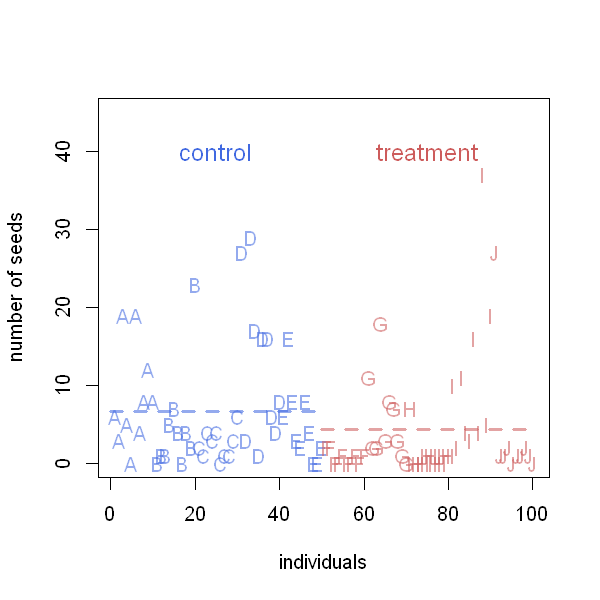

In [14]:
d <- read.csv("d1.csv")

#fig. 10.7(A)
plot(d$id,d$y, pch = as.character(d$pot), ylim = c(0, 45),
     xlab = "individuals", ylab = "number of seeds", 
     col = c(rep("#4169E190", 50), rep("#CD5C5C90", 50)))
lines(c(0,50), c(rep(mean(d$y[d$f == "C"]),2)), 
      lwd = 3, lty =2, col = "#4169E190")
lines(c(50,100), c(rep(mean(d$y[d$f == "T"]),2)), 
      lwd = 3, lty =2, col = "#CD5C5C90")
text(25, 40, "control", cex = 1.2, col = "#4169E1")
text(75, 40, "treatment", cex = 1.2, col = "#CD5C5C")

無処理である$i\in \{1, 2, …, 50\}(植木鉢\{A, …, E\})$の標本平均は<font color="Red">$8$</font>くらい

$y_i$がポアソン分布にしたがうなら標本標準偏差は$\sqrt 8=$<font color="Red">$2.83$</font>くらい

$8>2.83$なので明らかな<font color="Red">過分散</font>が発生している

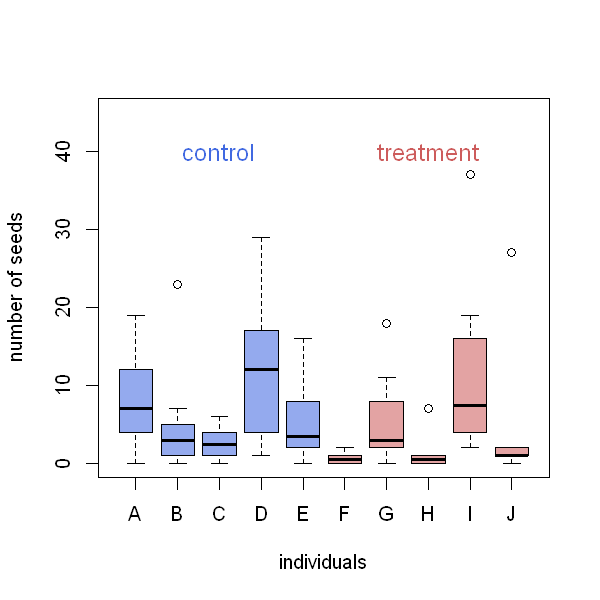

In [15]:
#fig. 10.7(B)
plot(d$pot,d$y, col = c(rep("#4169E190", 5), rep("#CD5C5C90", 5)), 
     ylim = c(0, 45),
     xlab = "individuals", ylab = "number of seeds")
text(3, 40, "control", cex = 1.2, col = "#4169E1")
text(8, 40, "treatment", cex = 1.2, col = "#CD5C5C")

In [16]:
options(repr.plot.width=6, repr.plot.height=6)

過分散の原因は**個体差**だけでなく**植木鉢の差**にもありそう

個体も植木鉢もどちらも反復ではなく<font color="Red">疑似反復</font>なので、**個体差**と**植木鉢差**を同時にあつかう統計モデルが必要

個体$i$の種子数$y_i$のばらつきを平均$\lambda_i$のポアソン分布で表現する。

$$p(y_i\mid \lambda_i)=\frac{{\lambda_i}^{y_i}\exp (-\lambda_i)}{y_i!}$$

線形予測子と対数リンク関数を使って平均種子数$\lambda_i$は、

$$\log \lambda_i=\beta_1+\beta_2f_i+r_i+r_{j(i)}$$


> $\beta_1: 切片$  
> $f_i:$ 施肥処理の有無をあらわす因子型の説明変数  
> $\beta_2: f_i$の係数  
> $r_i: 個体i$の効果  
>$r_{j(i)}: 植木鉢j$の効果

$r_i$は100個、$r_{j(i)}$は10個あり、それぞれのばらつきを$s、s_p$とする。

パラメーターの事前分布

+ **大域的**な平均パラメーターである$\beta_1$と$\beta_2$は<font color="Red">無情報事前分布</font>、平均0の押しつぶされた正規分布

+ **大域的**なばらつきパラメーターである$s$と$s_p$は<font color="Red">無情報事前分布</font>、0から$10^4$の範囲をとる一様分布

+ **局所的**パラメーターである$r_i$と$r_{j(i)}$は<font color="Red">階層事前分布</font>、平均0、標準偏差はそれぞれ$s$と$s_p$

あとはWinBUGSなどを使って事後分布推定

この統計モデルのBUGSコード
```

model
{
	for (i in 1:N.sample) {
		Y[i] ~ dpois(lambda[i])
		log(lambda[i]) <- beta1 + beta2 * F[i] + r[i] + rp[Pot[i]]
	}
	beta1 ~ dnorm(0, 1.0E-4)
	beta2 ~ dnorm(0, 1.0E-4)
	for (i in 1:N.sample) {
		r[i] ~ dnorm(0, tau[1])
	}
	for (j in 1:N.pot) {
		rp[j] ~ dnorm(0, tau[2])
	}
	for (k in 1:N.tau) {
		tau[k] <- 1.0 / (s[k] * s[k])
		s[k] ~ dunif(0, 1.0E+4)
	}
}

```

<img  src="fig. 10.8.jpeg"/>

### Rで実行

In [17]:
clear.data.param()
set.data("N.sample", nrow(d))
set.data("N.pot", length(levels(d$pot)))
set.data("N.tau", 2)

set.data("Y", d$y)
set.data("F", as.numeric(d$f == "T"))
set.data("Pot", as.numeric(d$pot))

set.param("beta1", 0)
set.param("beta2", 0)
set.param("s", c(1, 1))
set.param("r", rnorm(N.sample, 0, 0.1))
set.param("rp", rnorm(N.pot, 0, 0.1))

In [ ]:
post.bugs <- call.bugs(
  file = "model.bug10.5.txt",
  n.iter = 51000, n.burnin = 1000, n.thin = 50
)

＊あらかじめRStudioで実行処理した結果を保存し、load()する。

In [18]:
load("Chap. 10.5.RData")

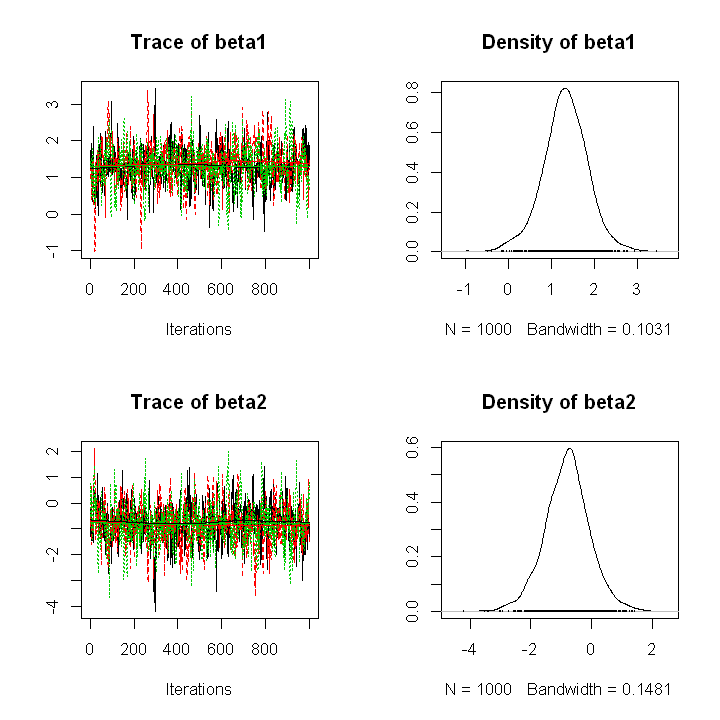

In [19]:
post.list <- to.list(post.bugs)
post.mcmc <- to.mcmc(post.bugs)

s <- colnames(post.mcmc) %in% c("beta1","beta2")
plot(post.list[,s,]) #"beta1"と"beta2"の列を選択して図示

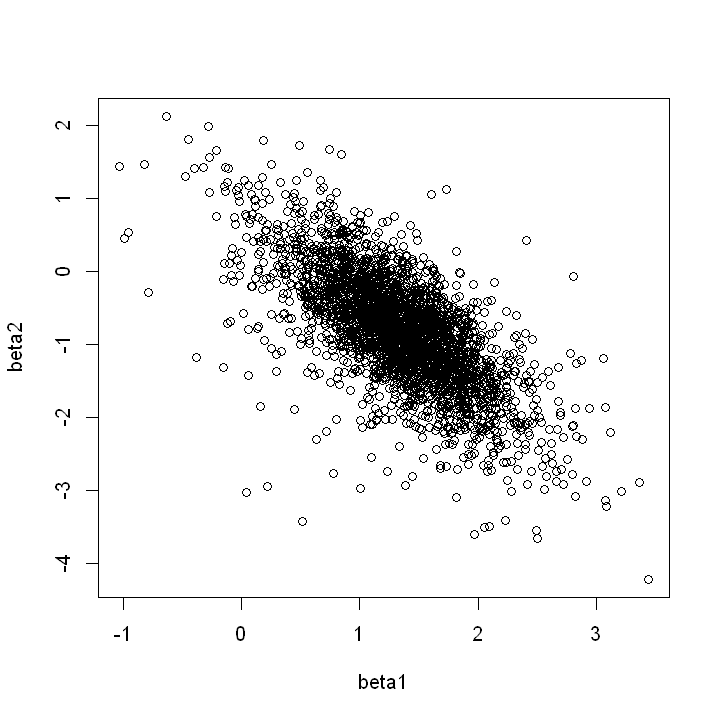

In [20]:
#パラメーター間の分布
plot(as.matrix(post.mcmc)[,c("beta1","beta2")])

In [21]:
#MCMCサンプリングの要約
print(post.bugs, digits.summary = 3)

Inference for Bugs model at "C:/Users/schaf/OneDrive/Documents/Ryo Nakahata/5.Statistic/R directry/model.bug10.5.txt", fit using WinBUGS,
 3 chains, each with 51000 iterations (first 1000 discarded), n.thin = 50
 n.sims = 3000 iterations saved
            mean     sd    2.5%     25%     50%     75%   97.5%  Rhat n.eff
beta1      1.330  0.533   0.180   1.018   1.344   1.664   2.382 1.008   340
beta2     -0.801  0.762  -2.359  -1.266  -0.782  -0.338   0.742 1.004   700
s[1]       1.019  0.117   0.817   0.937   1.010   1.092   1.273 1.001  2300
s[2]       1.062  0.394   0.519   0.795   0.991   1.243   2.056 1.002  1300
r[1]      -0.033  0.482  -1.008  -0.342  -0.022   0.294   0.877 1.003   980
r[2]      -0.578  0.552  -1.693  -0.937  -0.567  -0.201   0.484 1.001  3000
r[3]       1.099  0.396   0.311   0.843   1.100   1.360   1.874 1.002  1300
r[4]      -0.199  0.501  -1.205  -0.514  -0.192   0.136   0.740 1.003   710
r[5]      -1.571  0.722  -3.080  -2.019  -1.540  -1.071  -0.284 1.001  3

このようにして事後分布を推定してみると、$\beta_2$の（周辺）事後分布の$95\%$区間は<font color="Red">－2.36から0.74</font>（教科書では－2.47から0.70）くらいとなり、施肥処理は何の効果もなさそうだとわかる。

## 10.6 この章のまとめと参考文献
+ GLMMをベイズモデル化すると**階層ベイズモデル**になる
+ 階層ベイズモデルとは、事前分布となる確率分布のパラメーターにも事前分布が指定されている統計モデルである
+ 無情報事前分布と階層事前分布を使うことで、ベイズ統計モデルから主観的な事前分布を排除できる
+ **個体差＋場所差**といった複雑な構造のあるデータの統計モデリングでは、階層ベイズモデルとMCMCサンプリングによるパラメーター推定の組み合わせで対処するのが良い

統計モデルと推定方法の区別に注意  
統計モデルは<font color="Red">階層ベイズモデル</font>、推定方法は<font color="Red">MCMCサンプリング</font>